In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

In [0]:
from keras.layers import *
from keras.layers.merge import concatenate
from keras.models import Model
from keras.backend import reverse

In [0]:
max_words = 30000
max_words_length = 400
embedding_dimension = 300

lstm_options = {
    'units': 64,
    'dropout': 0.2,
    'return_sequences': True
}

convolution_options = {
    'filters': 300,
    'kernel_size': 1,
    'strides': 1,
    'padding': 'valid'
}

In [0]:
def forward_lstm(comment_embedding):
    lstm = CuDNNLSTM(
        units=lstm_options['units'], 
        return_sequences=lstm_options['return_sequences']
    )(comment_embedding)
    lstm = Dropout(lstm_options['dropout'])(lstm)
    
    return lstm

def backward_lstm(comment_embedding):
    reversed_embeddings = Lambda(lambda x: reverse(x, axes=1))(comment_embedding)
    lstm = CuDNNLSTM(
        units=lstm_options['units'], 
        return_sequences=lstm_options['return_sequences']
    )(reversed_embeddings)   
    lstm = Dropout(lstm_options['dropout'])(lstm)

    return Lambda(lambda x: reverse(x, axes=1))(lstm)

def convolution_block(context, options):
    convolution_block = Conv1D(
        options['filters'], 
        options['kernel_size'], 
        strides=options['strides'],
        padding=options['padding'], 
        activation='linear', 
        kernel_initializer='he_normal'
    )(context)
    convolution_block = BatchNormalization()(convolution_block)
    convolution_block = Activation('tanh')(convolution_block)

    return convolution_block

In [0]:
def yoon_kim_feature_extractor(input_layer, filters):
    extractor_block_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])

    block_1_conv_1 = Conv1D(filters, 1, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_batchnorm1 = ELU()(block_1_batchnorm1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filters, 2, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_batchnorm2 = ELU()(block_1_batchnorm2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filters, 3, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_batchnorm3 = ELU()(block_1_batchnorm3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filters, 5, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_batchnorm4 = ELU()(block_1_batchnorm4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    
    extractor_block_output = Dropout(0.2)(features)
    
    return Model(
        inputs=[extractor_block_input], 
        outputs=[extractor_block_output]
    )(input_layer)

In [0]:
def single_category_regressor(features, units, dropout_rate=0.2):
    model = Dense(units, activation='linear', kernel_initializer='he_normal')(input_layer)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    model = Dense(units, activation='linear', kernel_initializer='he_normal')(model)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)
    
    return Dense(1, activation='sigmoid', kernel_initializer='glorot_normal')

def classification_block(input_layer, dropout_rate=0.2):
    model = Dense(256, activation='linear', kernel_initializer='he_normal')(input_layer)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    model = Dense(256, activation='linear', kernel_initializer='he_normal')(model)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)
    
    model = Dense(6, activation='sigmoid', kernel_initializer='glorot_normal')(model)
    
    single_category_layer = concatenate([
        single_category_regressor(features, 128, dropout_rate),
        single_category_regressor(features, 128, dropout_rate),
        single_category_regressor(features, 128, dropout_rate),
        single_category_regressor(features, 128, dropout_rate),
        single_category_regressor(features, 128, dropout_rate),
        single_category_regressor(features, 128, dropout_rate)
    ])

    return average([model, single_category_layer])


In [13]:
input_layer = Input(shape=(max_words_length,))

pretrained_embedding_layer = Embedding(
    max_words,
    output_dim=embedding_dimension,
    input_length=max_words_length,
    weights=[np.load('fast_text_embeddings.npy')],
    trainable=False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    max_words,
    output_dim=embedding_dimension,
    input_length=max_words_length,
    weights=[np.load('custom_fast_text_embeddings.npy')],
    trainable=False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

averaged_embedding_layer = Average()([pretrained_embedding_layer, custom_embedding_layer])
averaged_embedding_layer = SpatialDropout1D(0.2)(averaged_embedding_layer)

context = concatenate([
    forward_lstm(averaged_embedding_layer),
    averaged_embedding_layer,
    backward_lstm(averaged_embedding_layer)
])
context = Dropout(0.2)(context)

scaled_context = convolution_block(context, convolution_options)
pooled_features = concatenate([
    yoon_kim_feature_extractor(scaled_context, convolution_options['filters']),
    GlobalMaxPooling1D()(scaled_context),
    GlobalAveragePooling1D()(scaled_context)
])

output_layer = classification_block(pooled_features, dropout_rate=0.2)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [14]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
102124/102124 [==============================] - 828s 8ms/step - loss: 0.0718 - acc: 0.9748 - val_loss: 0.0470 - val_acc: 0.9820===>.] - ETA: 0s - loss: 0.0718 - acc: 0.974
Epoch 2/32
 10144/102124 [=>............................] - ETA: 11:28 - loss: 0.0547 - acc: 0.9800102112/102124 [============================>.] - ETA: 0s - loss: 0.0513 - acc: 0.9810102124/102124 [==============================] - 823s 8ms/step - loss: 0.0513 - acc: 0.9810 - val_loss: 0.0424 - val_acc: 0.9836
roc-auc: 0.9856 - roc-auc_val: 0.9823                                                                                                    
Epoch 3/32
102124/102124 [==============================] - 826s 8ms/step - loss: 0.0478 - acc: 0.9820 - val_loss: 0.0412 - val_acc: 0.9842===>.] - ETA: 0s - loss: 0.0478 - acc: 0.982
Epoch 4/32
 10144/102124 [=>............................] - ETA: 11:33 - loss: 0.0434 - acc: 0.9832102112/102124 [================

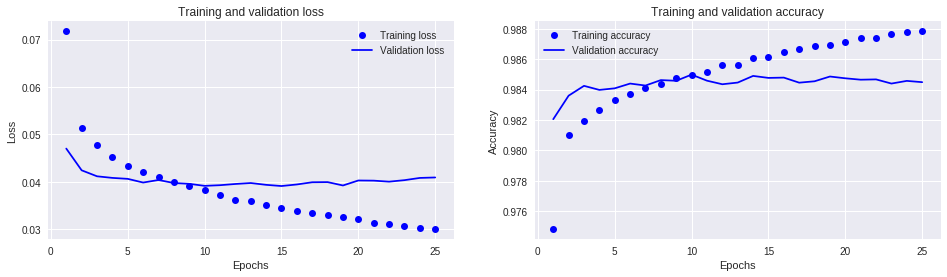

In [15]:
plot_history(history)

In [16]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 75s 2ms/step
([0.03951239349802315, 0.9848608157953349], 0.9905174813350864)
